#Financial Trading with Python, 2nd Edition
Cordell L. Tanny, CFA, FRM, FDP

## Chapter 3: Setting up a Python Quantitative Workflow
### Notebook 3.1: Data Concepts Lab

Version: 1

Date of last revision: January 17, 2026

This notebook demonstrates the key data concepts covered in Chapter 3. We will explore the differences between close and adjusted close prices, see how splits and dividends affect historical data, understand volume adjustments, and visualize the noise inherent in financial data.

*Note and recommendation: Very often, you might want to experiment on your own as you go through this notebook. We recommend you save a copy of this notebook before you start adding cells or changing anything. This way you always have a pristine copy to go back to.*

---

## Setup

First, let's import the packages we need and set some display options.

In [ ]:
# Install yfinance if needed (uncomment if running in Colab)
# !pip install yfinance --quiet

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

# Display settings
pd.set_option('display.max_rows', 20)
pd.set_option('display.float_format', '{:.2f}'.format)
warnings.filterwarnings('ignore')

# Plot settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

**Utility function:**

Recent versions of yfinance return data with MultiIndex columns (e.g., (`Close`, `AAPL`) instead of just `Close`). This can cause errors when accessing columns directly or performing calculations. The following utility function flattens the MultiIndex to simple column names. We will use it throughout this notebook when needed.

In [33]:
def flatten_columns(df):
    """Flatten MultiIndex columns from yfinance to single level."""
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
    return df

---

## Section 1: Close vs. Adjusted Close

The adjusted close price accounts for corporate actions like stock splits and dividends. It allows us to calculate accurate returns over time. Let's download Apple (AAPL) data and see how these two prices differ.

AAPL is a good example because it has undergone multiple splits and pays quarterly dividends.

*Note: Focus on the concepts and output. We will cover all of the code needed to download data in Notebook 3.2.*

In [2]:
# Download AAPL data with auto_adjust=False to see both Close and Adj Close
aapl = yf.download('AAPL', start='2014-01-01', end='2024-12-31', auto_adjust=False, progress=False)

print(f"Data shape: {aapl.shape}")
print(f"Date range: {aapl.index[0].strftime('%Y-%m-%d')} to {aapl.index[-1].strftime('%Y-%m-%d')}")
print(f"\nColumns: {list(aapl.columns)}")

Data shape: (2767, 6)
Date range: 2014-01-02 to 2024-12-30

Columns: [('Adj Close', 'AAPL'), ('Close', 'AAPL'), ('High', 'AAPL'), ('Low', 'AAPL'), ('Open', 'AAPL'), ('Volume', 'AAPL')]


Note: You may notice the columns display as a MultiIndex (e.g., (`Close`, `AAPL`) rather than just `Close`). This is how yfinance structures the output when downloading data. It can be a minor annoyance when working with single tickers. We will show you how to flatten this to simple column names in Notebook 3.2.

In [4]:
# Look at the most recent data
aapl[['Close', 'Adj Close']].tail(10)

Price,Close,Adj Close
Ticker,AAPL,AAPL
Date,,
2024-12-16,251.04,249.91
2024-12-17,253.48,252.34
2024-12-18,248.05,246.93
2024-12-19,249.79,248.67
2024-12-20,254.49,253.34
2024-12-23,255.27,254.12
2024-12-24,258.20,257.04
2024-12-26,259.02,257.85


Notice that `Close` and `Adj Close` are very close to each other in recent data. The difference grows as we look further back in time because adjustments accumulate.

In [5]:
# Look at older data - the difference is more pronounced
aapl[['Close', 'Adj Close']].head(10)

Price,Close,Adj Close
Ticker,AAPL,AAPL
Date,,
2014-01-02,19.75,17.16
2014-01-03,19.32,16.78
2014-01-06,19.43,16.87
2014-01-07,19.29,16.75
2014-01-08,19.41,16.86
2014-01-09,19.16,16.64
2014-01-10,19.03,16.53
2014-01-13,19.13,16.62


In [6]:
# Calculate the percentage difference between Close and Adj Close
aapl['Pct_Diff'] = ((aapl['Close'] - aapl['Adj Close']) / aapl['Close']) * 100

print(f"Percentage difference at start of data: {aapl['Pct_Diff'].iloc[0]:.2f}%")
print(f"Percentage difference at end of data: {aapl['Pct_Diff'].iloc[-1]:.2f}%")

Percentage difference at start of data: 13.15%
Percentage difference at end of data: 0.45%


The `Close` and `Adj Close` prices are nearly identical at the end of our data (only 0.45% difference) because few adjustments have been applied to recent prices. At the start of our data in 2014, the difference is over 13%. This gap represents ten years of accumulated dividend adjustments and the 4-for-1 stock split in 2020. The further back you look, the larger the divergence becomes.

Let's plot both the `Close` and `Adj Close` for comparison. We will cover plotting in the next chapter, so please just focus on the output.

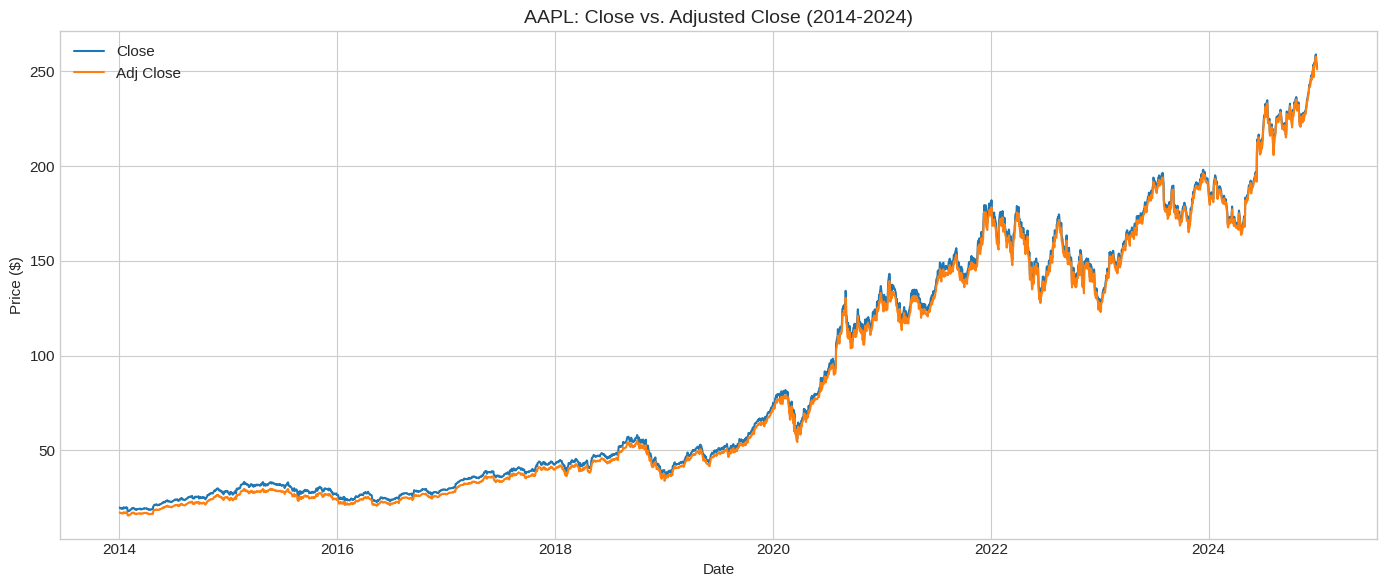

In [7]:
# Plot both prices over time
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(aapl.index, aapl['Close'], label='Close', linewidth=1.5)
ax.plot(aapl.index, aapl['Adj Close'], label='Adj Close', linewidth=1.5)

ax.set_title('AAPL: Close vs. Adjusted Close (2014-2024)', fontsize=14)
ax.set_xlabel('Date')
ax.set_ylabel('Price ($)')
ax.legend()

plt.tight_layout()
plt.show()

The gap between the two lines represents the cumulative effect of all dividends paid over this period. The adjusted close is lower because it retroactively removes the dividend amounts from historical prices.

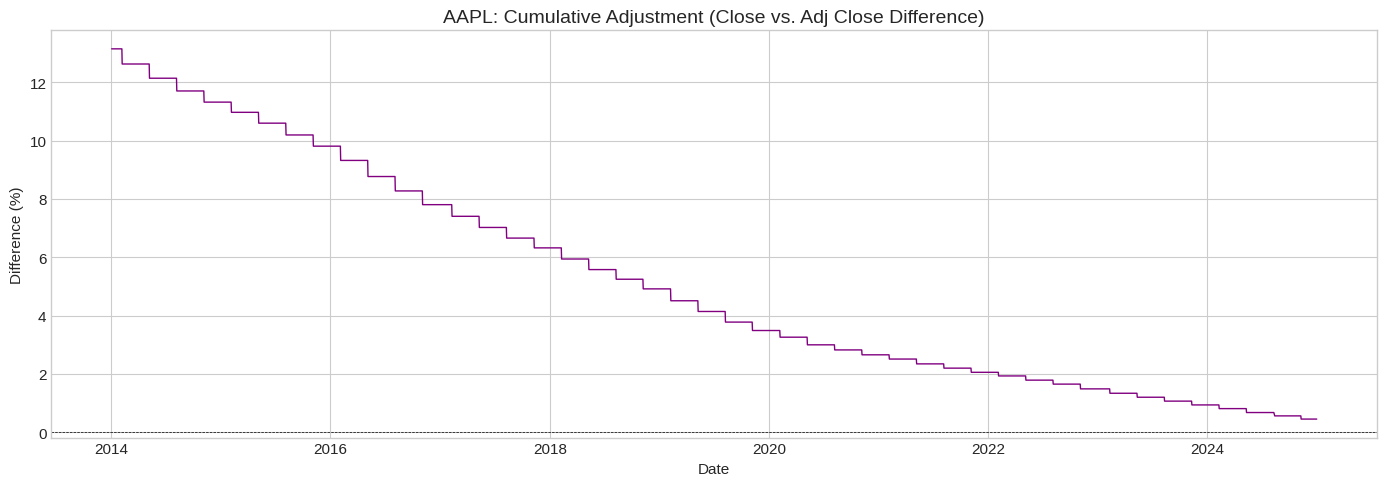

In [8]:
# Plot the percentage difference over time
fig, ax = plt.subplots(figsize=(14, 5))

ax.plot(aapl.index, aapl['Pct_Diff'], color='purple', linewidth=1)
ax.axhline(y=0, color='black', linestyle='--', linewidth=0.5)

ax.set_title('AAPL: Cumulative Adjustment (Close vs. Adj Close Difference)', fontsize=14)
ax.set_xlabel('Date')
ax.set_ylabel('Difference (%)')

plt.tight_layout()
plt.show()

The stair-step pattern shows dividend adjustments being applied. Each drop corresponds to an ex-dividend date. The large drops are stock splits.

---

## Section 2: Stock Splits in Action

Apple had a 4-for-1 stock split on August 31, 2020. Let's zoom in on this period and see what happens to the price data.

In [9]:
# Get the split information from yfinance
aapl_ticker = yf.Ticker('AAPL')
splits = aapl_ticker.splits

print("AAPL Stock Splits:")
print(splits[splits > 0].to_string())

AAPL Stock Splits:
Date
1987-06-16 00:00:00-04:00   2.00
2000-06-21 00:00:00-04:00   2.00
2005-02-28 00:00:00-05:00   2.00
2014-06-09 00:00:00-04:00   7.00
2020-08-31 00:00:00-04:00   4.00


We can download and isolate all of the split data from Yahoo! Finance quite easily. Notice that the output shows the split ratio. `7` indicates that there was a 7-for-1 split, and you would have received 7 shares for every one that you owned. The `4` in 2020 represents the more recent 4-for-1 split.

Apple had a 4-for-1 stock split on August 31, 2020. In the past, downloading data with `auto_adjust=False` would show you the raw unadjusted prices, and you would see what looked like a 75% crash on the split date. However, Yahoo Finance has changed their backend over time. The `Close` column now returns split-adjusted prices regardless of the `auto_adjust` setting.
This is actually good news for most users since you are less likely to accidentally use unadjusted data. But it means we cannot demonstrate the "fake crash" with live yfinance data.
Here is what you need to understand: if you ever work with truly unadjusted data from another source, a 4-for-1 split would show the price dropping from approximately $500 to $125 overnight. Your return calculation would show a -75% loss on a day when investors actually made money. This is why understanding splits matters, even if yfinance protects you from this particular mistake.

In [12]:
# Zoom in on the August 2020 split period
# isolate the specific time range with .loc
split_period = aapl.loc['2020-08-20':'2020-09-10', ['Close', 'Adj Close']].copy()
split_period

Price,Close,Adj Close
Ticker,AAPL,AAPL
Date,,
2020-08-20,118.28,114.94
2020-08-21,124.37,120.86
2020-08-24,125.86,122.31
2020-08-25,124.82,121.30
2020-08-26,126.52,122.95
2020-08-27,125.01,121.48
2020-08-28,124.81,121.28
2020-08-31,129.04,125.40


Notice that both `Close` and `Adj Close` show similar values with no dramatic discontinuity. The split has been adjusted in both columns.

### Split Detection

How do you detect if your data has unadjusted splits? Look for sudden large percentage drops on known split dates.

In [15]:
def detect_potential_splits(df, price_col='Close', threshold=-0.40):
    """
    Detect potential split dates by finding large single-day drops.

    Parameters:
    -----------
    df : DataFrame with price data
    price_col : column name for price
    threshold : minimum percentage drop to flag (e.g., -0.40 = 40% drop)

    Returns:
    --------
    DataFrame with potential split dates and drop percentages
    """
    # Handle MultiIndex columns from yfinance
    if isinstance(df.columns, pd.MultiIndex):
        prices = df[price_col].iloc[:, 0]  # Get first ticker's data
    else:
        prices = df[price_col]

    returns = prices.pct_change()
    potential_splits = returns[returns < threshold]

    result = pd.DataFrame({
        'Date': potential_splits.index,
        'Drop_Pct': (potential_splits.values * 100).round(2)
    })

    return result

This function scans a price series for single-day drops exceeding a threshold (default 40%). If you run it on our AAPL data, it will find nothing because yfinance has already adjusted for splits. That is the expected result for clean data.

In [16]:
# Detect potential splits in AAPL Close data
potential_splits = detect_potential_splits(aapl, 'Close', threshold=-0.40)

if len(potential_splits) == 0:
    print("No large price drops detected. The data is already split-adjusted.")
else:
    print("Potential split dates detected from large price drops:")
    print(potential_splits.to_string(index=False))

No large price drops detected. The data is already split-adjusted.


**Key Takeaway**
Stock splits can make historical price data unusable if not properly adjusted. A 4-for-1 split creates a 75% drop in unadjusted data that would corrupt any return calculation or trading signal. Always verify your data is split-adjusted before using it. If you encounter data from a source that does not adjust for splits, the detection function above can help you identify the problem dates. Better yet, find a different data source.

---

## Section 3: Dividend Adjustments

Dividends also affect the adjusted close price. Let's look at a high-dividend stock to see this effect more clearly. We will use Verizon (VZ), a telecommunications company known for its consistent dividend payments.

In [17]:
# Download Verizon data
vz = yf.download('VZ', start='2010-01-01', end='2024-12-31', auto_adjust=False, progress=False)

print(f"Data shape: {vz.shape}")
print(f"Date range: {vz.index[0].strftime('%Y-%m-%d')} to {vz.index[-1].strftime('%Y-%m-%d')}")

Data shape: (3773, 6)
Date range: 2010-01-04 to 2024-12-30


In [18]:
# Get dividend history
vz_ticker = yf.Ticker('VZ')
dividends = vz_ticker.dividends

print(f"Number of dividend payments since 2010: {len(dividends[dividends.index >= '2010-01-01'])}")
print(f"\nRecent dividends:")
print(dividends.tail(10).to_string())

Number of dividend payments since 2010: 65

Recent dividends:
Date
2023-10-06 00:00:00-04:00   0.67
2024-01-09 00:00:00-05:00   0.67
2024-04-09 00:00:00-04:00   0.67
2024-07-10 00:00:00-04:00   0.67
2024-10-10 00:00:00-04:00   0.68
2025-01-10 00:00:00-05:00   0.68
2025-04-10 00:00:00-04:00   0.68
2025-07-10 00:00:00-04:00   0.68
2025-10-10 00:00:00-04:00   0.69
2026-01-12 00:00:00-05:00   0.69


Verizon pays dividends quarterly, which is typical for established companies. Over our data period, that adds up to a substantial number of payments. Each of these dividend payments triggers an adjustment to all historical `Adj Close` prices. The cumulative effect of 50+ dividend adjustments is why we see such a large gap between `Close` and `Adj Close` for high-dividend stocks.

In [19]:
# Calculate cumulative difference
vz['Pct_Diff'] = ((vz['Close'] - vz['Adj Close']) / vz['Close']) * 100

print(f"Cumulative adjustment at start: {vz['Pct_Diff'].iloc[0]:.2f}%")
print(f"Cumulative adjustment at end: {vz['Pct_Diff'].iloc[-1]:.2f}%")

Cumulative adjustment at start: 56.70%
Cumulative adjustment at end: 8.04%


The difference is striking. At the start of our data in 2010, the `Adj Close` is nearly 57% lower than the `Close`. This represents over a decade of dividend payments retroactively removed from the price. Even at the end of our data, there is still an 8% gap from recent dividends that have not yet compounded as far back. Compare this to AAPL's 13% gap, which included both dividends and a major stock split. VZ's 57% gap comes almost entirely from dividends. This is why dividend-adjusted prices are essential for evaluating income-oriented investments.

Let's plot the differences.

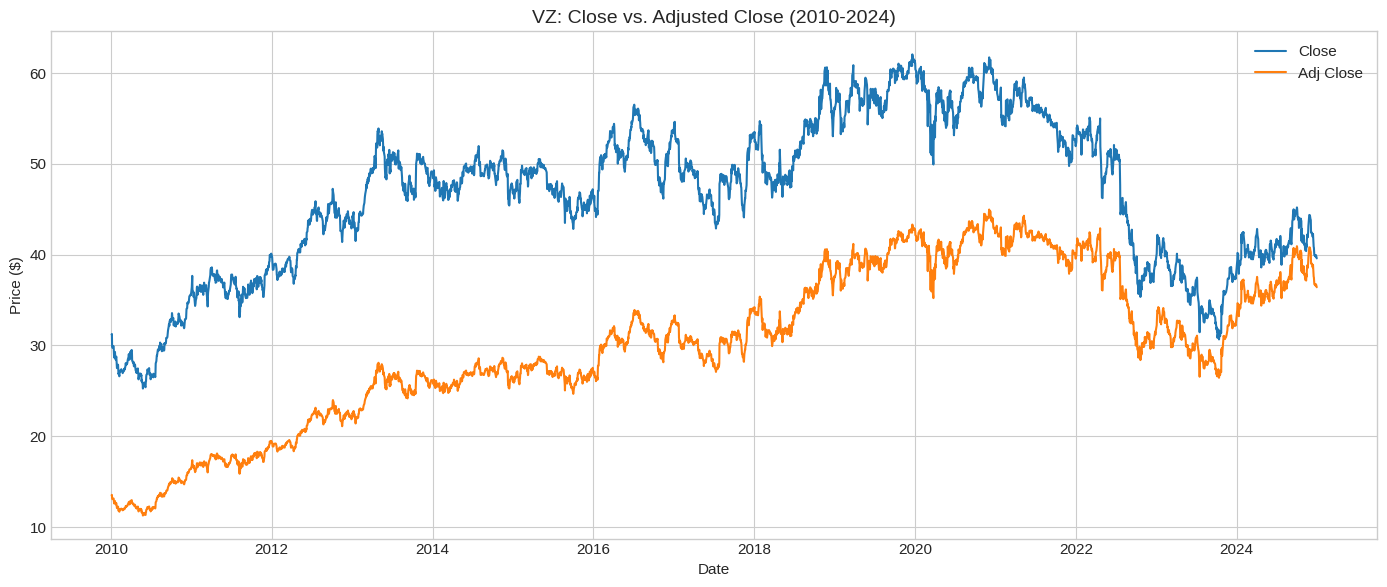

In [20]:
# Plot both prices
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(vz.index, vz['Close'], label='Close', linewidth=1.5)
ax.plot(vz.index, vz['Adj Close'], label='Adj Close', linewidth=1.5)

ax.set_title('VZ: Close vs. Adjusted Close (2010-2024)', fontsize=14)
ax.set_xlabel('Date')
ax.set_ylabel('Price ($)')
ax.legend()

plt.tight_layout()
plt.show()

The gap between Close and Adj Close represents all the dividends paid over this period. For a high-dividend stock like VZ, this gap is substantial.

We can quantify exactly how much of VZ's return came from price appreciation versus dividends. By comparing the return calculated from `Close` (price only) to the return from `Adj Close` (total return), the difference tells us the dividend contribution.

In [22]:
# Calculate total return from price appreciation vs. dividends
# Handle MultiIndex columns
if isinstance(vz.columns, pd.MultiIndex):
    close_prices = vz['Close'].iloc[:, 0]
    adj_close_prices = vz['Adj Close'].iloc[:, 0]
else:
    close_prices = vz['Close']
    adj_close_prices = vz['Adj Close']

price_return = (close_prices.iloc[-1] / close_prices.iloc[0] - 1) * 100
total_return = (adj_close_prices.iloc[-1] / adj_close_prices.iloc[0] - 1) * 100
dividend_contribution = total_return - price_return

print(f"VZ Performance (2010-2024):")
print(f"  Price return only:      {price_return:>8.2f}%")
print(f"  Total return (adj):     {total_return:>8.2f}%")
print(f"  Dividend contribution:  {dividend_contribution:>8.2f}%")
print(f"\nDividends accounted for {dividend_contribution/total_return*100:.1f}% of total return.")

VZ Performance (2010-2024):
  Price return only:         26.87%
  Total return (adj):       169.43%
  Dividend contribution:    142.56%

Dividends accounted for 84.1% of total return.


This demonstrates why performance comparisons must be done on a total return basis. Total return includes both price appreciation and income (dividends). The formula for a single period total return is:

**Total Return = (Ending Value - Beginning Value + Dividends) / Beginning Value**

When you use `Adj Close`, the dividend component is already baked into the price series. The adjustment retroactively lowers historical prices by the dividend amount, so the percentage change from one day to the next automatically captures the total return. If you use unadjusted Close prices, you are only measuring price appreciation and ignoring the income component entirely. For a stock like VZ where dividends account for the majority of total return, this would lead to a completely misleading comparison against a growth stock that pays no dividends.

---

## Section 4: Volume Adjustments

Volume data must also be adjusted for stock splits. When a stock splits 4-for-1, the number of shares outstanding quadruples. Post-split daily volume will naturally be higher simply because there are more shares trading. If you compared unadjusted volume before and after a split, it would look like trading activity exploded overnight.
Let's see how yfinance handles volume around the AAPL split.


In [26]:
# Download AAPL with auto_adjust=False
aapl_unadj = yf.download('AAPL', start='2020-08-01', end='2020-09-30', auto_adjust=False, progress=False)

# Download AAPL with auto_adjust=True
aapl_adj = yf.download('AAPL', start='2020-08-01', end='2020-09-30', auto_adjust=True, progress=False)

# Handle MultiIndex columns
if isinstance(aapl_unadj.columns, pd.MultiIndex):
    unadj_volume = aapl_unadj['Volume'].iloc[:, 0]
    adj_volume = aapl_adj['Volume'].iloc[:, 0]
else:
    unadj_volume = aapl_unadj['Volume']
    adj_volume = aapl_adj['Volume']

# Compare volume around the split
vol_comparison = pd.DataFrame({
    'auto_adjust=False': unadj_volume,
    'auto_adjust=True': adj_volume
})

vol_comparison.loc['2020-08-25':'2020-09-08']

,auto_adjust=False,auto_adjust=True
Date,,
2020-08-25,211495600,211495600
2020-08-26,163022400,163022400
2020-08-27,155552400,155552400
2020-08-28,187630000,187630000
2020-08-31,225702700,225702700
2020-09-01,151948100,151948100
2020-09-02,200119000,200119000
2020-09-03,257599600,257599600
2020-09-04,332607200,332607200


The volume is identical regardless of the auto_adjust setting. This reveals an important detail about yfinance: the auto_adjust parameter only controls whether price columns are adjusted and whether the Adj Close column appears. It does not affect volume or split adjustments. Yahoo Finance now returns split-adjusted volume by default, and there is no way to retrieve the raw unadjusted volume through yfinance.

In [27]:
# Verify they are exactly the same
print(f"Are volumes identical? {(unadj_volume == adj_volume).all()}")

Are volumes identical? True


What Unadjusted Volume Would Look Like
If you were working with truly unadjusted volume data, here is what you would see around a 4-for-1 split:

Before split: 10 million shares traded
After split: 40 million shares traded (for the same dollar volume)

The adjusted data multiplies all pre-split volume by the split ratio (4x in this case) so that volume is comparable across the entire history. A day that showed 10 million shares before the split would appear as 40 million in adjusted data.
If you encounter a data source where volume appears to spike dramatically on a known split date, that is a sign the volume has not been adjusted. You would need to multiply all pre-split volume by the split ratio to make it comparable.

**Key Takeaway**
Volume adjustments are handled automatically by yfinance. The auto_adjust parameter does not control this behavior. When working with other data sources, always verify whether volume has been adjusted for splits. Mixing adjusted prices with unadjusted volume, or vice versa, can produce misleading signals in any volume-based analysis.

---

## Section 5: Data Without Adjusted Close

Not all financial data requires adjustment. The VIX index is a calculated value derived from S&P 500 option prices. It is not a tradeable security, does not pay dividends, and does not split. Let's see what happens when we download it.

In [29]:
# Download VIX data
vix = yf.download('^VIX', start='2020-01-01', end='2024-12-31', auto_adjust=False, progress=False)

print(f"Columns: {list(vix.columns)}")
print(f"\nFirst few rows:")
vix.head()

Columns: [('Adj Close', '^VIX'), ('Close', '^VIX'), ('High', '^VIX'), ('Low', '^VIX'), ('Open', '^VIX'), ('Volume', '^VIX')]

First few rows:


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,^VIX,^VIX,^VIX,^VIX,^VIX,^VIX
Date,,,,,,
2020-01-02,12.47,12.47,13.72,12.42,13.46,0
2020-01-03,14.02,14.02,16.20,13.13,15.01,0
2020-01-06,13.85,13.85,16.39,13.54,15.45,0
2020-01-07,13.79,13.79,14.46,13.39,13.84,0
2020-01-08,13.45,13.45,15.24,12.83,15.16,0


The VIX data includes an `Adj Close` column, but is it actually different from `Close`? Let's check.

In [30]:
# Handle MultiIndex columns
if isinstance(vix.columns, pd.MultiIndex):
    close = vix['Close'].iloc[:, 0]
    adj_close = vix['Adj Close'].iloc[:, 0]
else:
    close = vix['Close']
    adj_close = vix['Adj Close']

# Check if they are identical
difference = (close - adj_close).abs()

print(f"Maximum difference between Close and Adj Close: {difference.max():.6f}")
print(f"Are they identical? {(difference == 0).all()}")

Maximum difference between Close and Adj Close: 0.000000
Are they identical? True


The Close and Adj Close columns are identical. yfinance includes the Adj Close column for consistency, but for indexes like VIX there is nothing to adjust. The same is true for interest rate indexes, currency pairs, and economic indicators. These are calculated values or rates, not securities that undergo corporate actions.
For our case study, this means we use Close for ^VIX data. Do not waste time looking for differences between Close and Adj Close for index data. They will always be the same.

In [31]:
# Same applies to interest rates - let's try the 10-Year Treasury
tnx = yf.download('^TNX', start='2020-01-01', end='2024-12-31', auto_adjust=False, progress=False)

tnx['Difference'] = tnx['Close'] - tnx['Adj Close']
print(f"10-Year Treasury (^TNX):")
print(f"Maximum difference between Close and Adj Close: {tnx['Difference'].abs().max():.6f}")
print(f"\nAgain, no adjustment needed for rate indexes.")

10-Year Treasury (^TNX):
Maximum difference between Close and Adj Close: 0.000000

Again, no adjustment needed for rate indexes.


**Key takeaway:**

When working with indexes, interest rates, or economic data, the adjusted close concept does not apply. Do not waste time looking for an Adj Close column that is different from Close. For these data types, they will always be identical.

---

## Section 6: Visualizing Noise

Financial data is inherently noisy. The VIX index, derived from options prices, is particularly volatile. Let's compare the daily movements of VIX versus SPY to see just how noisy financial data can be.

In [34]:
# Download SPY and VIX for comparison
spy = yf.download('SPY', start='2020-01-01', end='2024-12-31', auto_adjust=True, progress=False)
vix = yf.download('^VIX', start='2020-01-01', end='2024-12-31', auto_adjust=False, progress=False)

# Flatten MultiIndex columns
spy = flatten_columns(spy)
vix = flatten_columns(vix)

# Calculate daily percentage changes
spy_returns = spy['Close'].pct_change().dropna() * 100
vix_changes = vix['Close'].pct_change().dropna() * 100

print(f"SPY Daily Returns:")
print(f"  Mean:     {spy_returns.mean():>7.2f}%")
print(f"  Std Dev:  {spy_returns.std():>7.2f}%")
print(f"  Min:      {spy_returns.min():>7.2f}%")
print(f"  Max:      {spy_returns.max():>7.2f}%")

print(f"\nVIX Daily Changes:")
print(f"  Mean:     {vix_changes.mean():>7.2f}%")
print(f"  Std Dev:  {vix_changes.std():>7.2f}%")
print(f"  Min:      {vix_changes.min():>7.2f}%")
print(f"  Max:      {vix_changes.max():>7.2f}%")

SPY Daily Returns:
  Mean:        0.06%
  Std Dev:     1.32%
  Min:       -10.94%
  Max:         9.06%

VIX Daily Changes:
  Mean:        0.35%
  Std Dev:     8.40%
  Min:       -28.16%
  Max:        74.04%


The VIX has much higher volatility than SPY. Its standard deviation is roughly 5-6x that of SPY, and its daily swings can be enormous.

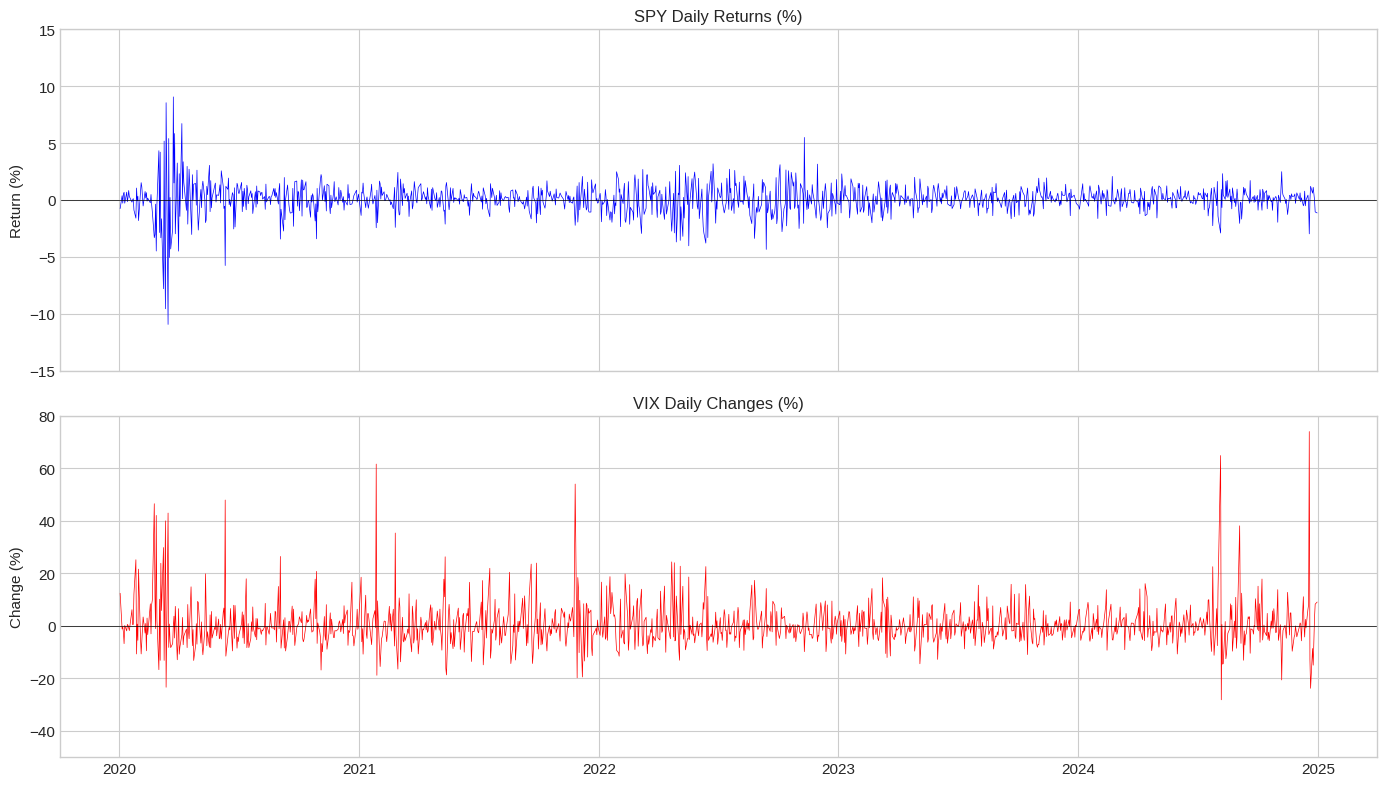

In [35]:
# Plot daily changes side by side
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

axes[0].plot(spy_returns.index, spy_returns.values, linewidth=0.5, color='blue')
axes[0].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[0].set_title('SPY Daily Returns (%)', fontsize=12)
axes[0].set_ylabel('Return (%)')
axes[0].set_ylim(-15, 15)

axes[1].plot(vix_changes.index, vix_changes.values, linewidth=0.5, color='red')
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[1].set_title('VIX Daily Changes (%)', fontsize=12)
axes[1].set_ylabel('Change (%)')
axes[1].set_ylim(-50, 80)

plt.tight_layout()
plt.show()

The difference in scale tells the story. SPY daily returns rarely exceed plus or minus 5%, even during the COVID crash in March 2020. VIX daily changes routinely swing 10% or more, with extreme moves exceeding 50% in both directions. Notice how VIX spikes violently during market stress (March 2020, early 2022) and then gradually subsides. This asymmetry is characteristic of volatility: it rises quickly and falls slowly. This is the noise we must work through when building signals from VIX data.

Another way to visualize noise is through the distribution of daily changes. A histogram shows how frequently different return magnitudes occur.

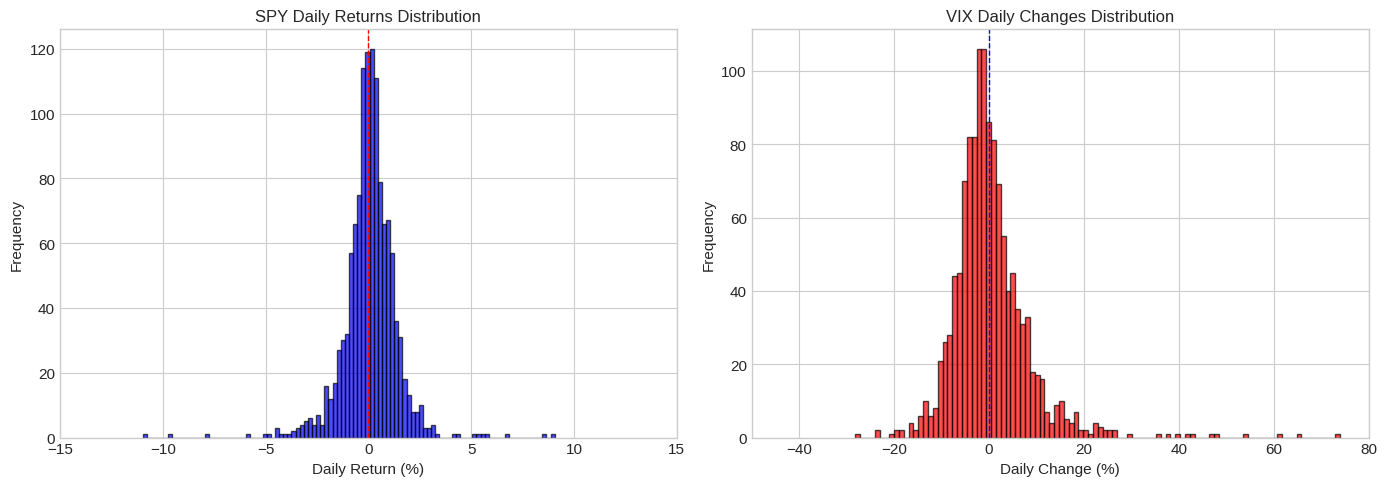

In [36]:
# Histogram comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(spy_returns, bins=100, edgecolor='black', alpha=0.7, color='blue')
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=1)
axes[0].set_title('SPY Daily Returns Distribution', fontsize=12)
axes[0].set_xlabel('Daily Return (%)')
axes[0].set_ylabel('Frequency')
axes[0].set_xlim(-15, 15)

axes[1].hist(vix_changes, bins=100, edgecolor='black', alpha=0.7, color='red')
axes[1].axvline(x=0, color='blue', linestyle='--', linewidth=1)
axes[1].set_title('VIX Daily Changes Distribution', fontsize=12)
axes[1].set_xlabel('Daily Change (%)')
axes[1].set_ylabel('Frequency')
axes[1].set_xlim(-50, 80)

plt.tight_layout()
plt.show()

Notice how the VIX distribution has much fatter tails and is positively skewed (large upward spikes are more common than equivalent downward moves). This is because VIX spikes during market panics, which are sudden and violent.

This noise is exactly why building reliable trading signals is difficult. The true signal is buried under all this random daily variation.

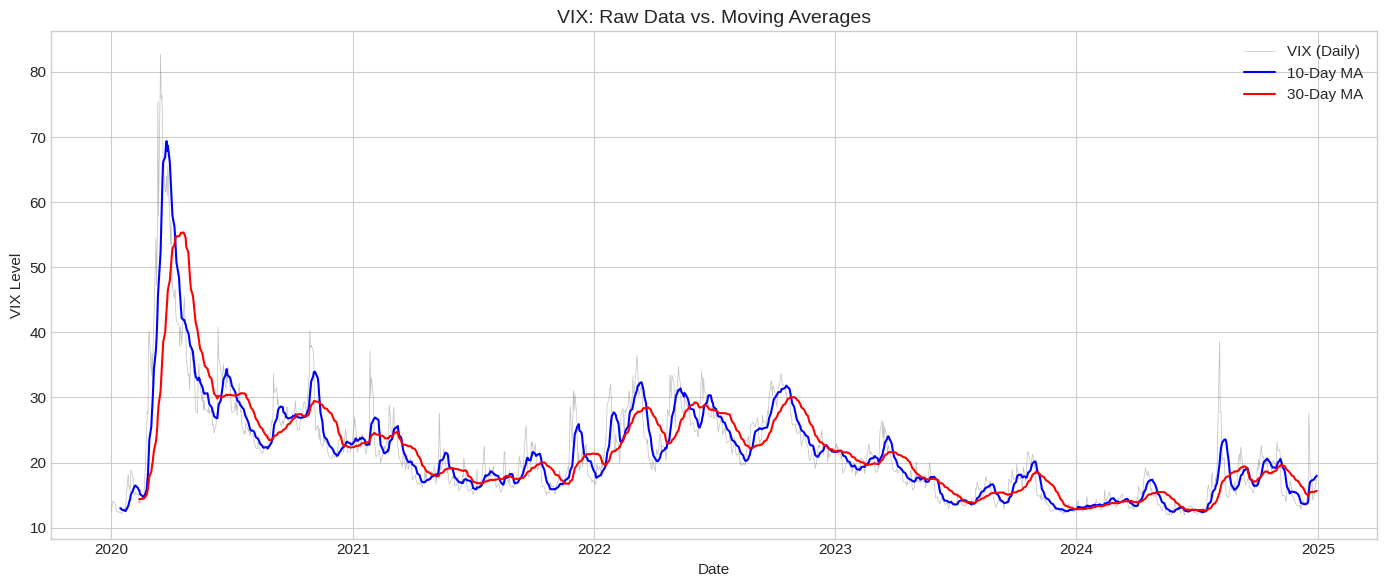

In [37]:
# Show how a moving average smooths the noise
vix_close = vix['Close'].copy()
vix_ma_10 = vix_close.rolling(window=10).mean()
vix_ma_30 = vix_close.rolling(window=30).mean()

fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(vix_close.index, vix_close.values, linewidth=0.5, alpha=0.5, label='VIX (Daily)', color='gray')
ax.plot(vix_ma_10.index, vix_ma_10.values, linewidth=1.5, label='10-Day MA', color='blue')
ax.plot(vix_ma_30.index, vix_ma_30.values, linewidth=1.5, label='30-Day MA', color='red')

ax.set_title('VIX: Raw Data vs. Moving Averages', fontsize=14)
ax.set_xlabel('Date')
ax.set_ylabel('VIX Level')
ax.legend()

plt.tight_layout()
plt.show()

Moving averages are the simplest way to reduce noise. The longer the window, the smoother the result, but the more lag introduced. This tradeoff between noise reduction and responsiveness is central to signal processing, which we will cover in Chapter 6.

---

## Section 7: History Coverage Check

Before building a strategy, you must know how much history you have for each data series. Let's check the availability of the four tickers we need for our VIXY tail hedge strategy.

In [38]:
# Download all four tickers with maximum history
tickers = ['SPY', 'BIL', 'VIXY', '^VIX']

data_info = []

for ticker in tickers:
    df = yf.download(ticker, start='1990-01-01', end='2024-12-31', auto_adjust=False, progress=False)

    info = {
        'Ticker': ticker,
        'Start Date': df.index[0].strftime('%Y-%m-%d'),
        'End Date': df.index[-1].strftime('%Y-%m-%d'),
        'Trading Days': len(df),
        'Years': round(len(df) / 252, 1)
    }
    data_info.append(info)

df_info = pd.DataFrame(data_info)
print("Data Availability Summary:")
print(df_info.to_string(index=False))

Data Availability Summary:
Ticker Start Date   End Date  Trading Days  Years
   SPY 1993-01-29 2024-12-30          8037  31.90
   BIL 2007-05-30 2024-12-30          4428  17.60
  VIXY 2011-01-04 2024-12-30          3520  14.00
  ^VIX 1990-01-02 2024-12-30          8816  35.00


Notice the different start dates:
- **SPY** goes back to 1993 (when it launched)
- **^VIX** goes back to 1990 (when CBOE started calculating it)
- **BIL** launched in 2007
- **VIXY** launched in 2011

VIXY is our limiting factor. Our backtest can only start in 2011, which means we miss the 2008 financial crisis entirely.

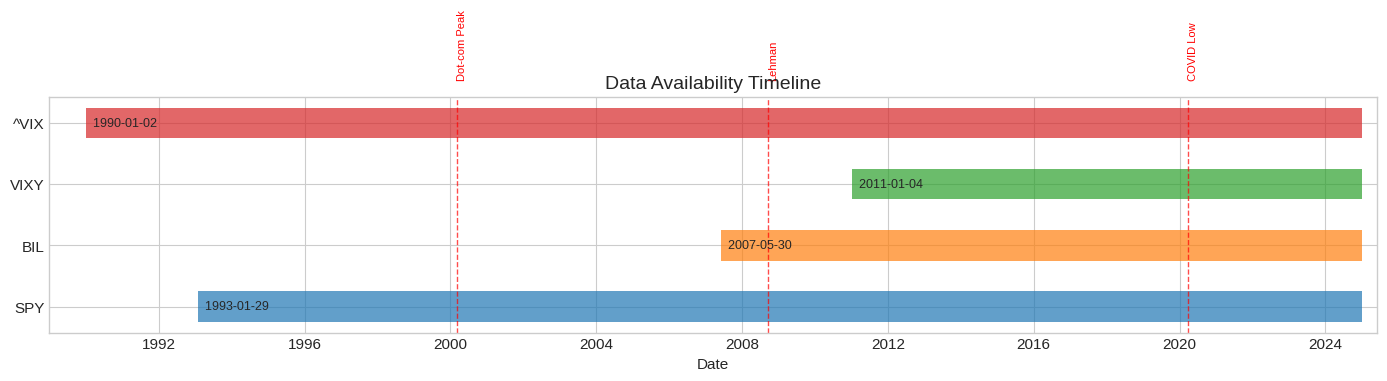

In [39]:
# Visualize the data availability as a timeline
fig, ax = plt.subplots(figsize=(14, 4))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for i, row in df_info.iterrows():
    start = pd.Timestamp(row['Start Date'])
    end = pd.Timestamp(row['End Date'])
    ax.barh(row['Ticker'], (end - start).days, left=start, height=0.5, color=colors[i], alpha=0.7)
    ax.text(start, i, f"  {row['Start Date']}", va='center', fontsize=9)

# Add vertical lines for key market events
events = [
    ('2000-03-10', 'Dot-com Peak'),
    ('2008-09-15', 'Lehman'),
    ('2020-03-23', 'COVID Low'),
]

for date, label in events:
    ax.axvline(x=pd.Timestamp(date), color='red', linestyle='--', linewidth=1, alpha=0.7)
    ax.text(pd.Timestamp(date), len(tickers) - 0.3, label, rotation=90, va='bottom', fontsize=8, color='red')

ax.set_title('Data Availability Timeline', fontsize=14)
ax.set_xlabel('Date')
ax.set_xlim(pd.Timestamp('1989-01-01'), pd.Timestamp('2025-06-01'))

plt.tight_layout()
plt.show()

In [40]:
# Find the common date range where all tickers have data
latest_start = df_info['Start Date'].max()
earliest_end = df_info['End Date'].min()

print(f"Common date range where all tickers have data:")
print(f"  Start: {latest_start}")
print(f"  End:   {earliest_end}")

# Calculate usable history
start_dt = pd.Timestamp(latest_start)
end_dt = pd.Timestamp(earliest_end)
trading_days = np.busday_count(start_dt.date(), end_dt.date())
years = trading_days / 252

print(f"\nUsable history:")
print(f"  Approximately {trading_days:,} trading days")
print(f"  Approximately {years:.1f} years")

Common date range where all tickers have data:
  Start: 2011-01-04
  End:   2024-12-30

Usable history:
  Approximately 3,649 trading days
  Approximately 14.5 years


Our usable history is constrained by VIXY, which launched in January 2011. While 14.5 years and nearly 3,650 trading days sounds like plenty of data, remember what we are missing: the 2008 financial crisis. For a tail hedge strategy designed to protect against market crashes, not being able to test against the worst financial crisis in modern history is a significant limitation. We have the data we have, and we will work with it, but this constraint should temper our confidence in any backtest results.

In [41]:
# Check what market events we can and cannot test
print("Market Events Coverage Check:")
print("="*50)

events_check = [
    ('2000-2002', 'Dot-com Bust', '2000-03-01'),
    ('2008-2009', 'Great Financial Crisis', '2008-01-01'),
    ('2011-2012', 'European Debt Crisis', '2011-07-01'),
    ('2015', 'China Devaluation', '2015-08-01'),
    ('2018 Q4', 'Fed Tightening Selloff', '2018-10-01'),
    ('2020', 'COVID Crash', '2020-02-01'),
    ('2022', 'Inflation/Rate Shock', '2022-01-01'),
]

vixy_start = pd.Timestamp('2011-01-04')  # VIXY launch date

for period, event, check_date in events_check:
    check_dt = pd.Timestamp(check_date)
    if check_dt >= vixy_start:
        status = "✓ INCLUDED"
    else:
        status = "✗ MISSING"
    print(f"{period:12} {event:30} {status}")

Market Events Coverage Check:
2000-2002    Dot-com Bust                   ✗ MISSING
2008-2009    Great Financial Crisis         ✗ MISSING
2011-2012    European Debt Crisis           ✓ INCLUDED
2015         China Devaluation              ✓ INCLUDED
2018 Q4      Fed Tightening Selloff         ✓ INCLUDED
2020         COVID Crash                    ✓ INCLUDED
2022         Inflation/Rate Shock           ✓ INCLUDED


### Key Takeaway

Our VIXY tail hedge strategy cannot be tested against the 2008 financial crisis, which is precisely the kind of event a tail hedge should protect against. This is a significant limitation that we must acknowledge when evaluating our backtest results.

The strategy does cover:
- The 2011 European debt crisis
- The 2015 China devaluation shock
- The 2018 Q4 selloff
- The 2020 COVID crash (fastest bear market in history)
- The 2022 inflation/rate shock

This gives us multiple volatility spikes to test against, but we should remain humble about our results given the missing 2008 data.

---

## Summary

In this notebook, we explored the key data concepts that every quantitative trader must understand:

1. **Close vs. Adjusted Close**: Adjusted close accounts for splits and dividends, allowing accurate return calculations. The gap between them grows over time.

2. **Stock Splits**: Unadjusted data would show dramatic "crashes" on split dates. yfinance now returns split-adjusted prices by default, even with `auto_adjust=False`. This protects you from accidental errors but means you cannot retrieve truly raw data through this package.

3. **Dividend Adjustments**:  For high-dividend stocks like VZ, dividends can account for the majority of total return. Performance comparisons must use total return (price appreciation plus dividends), which is what `Adj Close` provides.

4. **Volume Adjustments**: Volume must be adjusted for splits to maintain comparability. yfinance handles this automatically regardless of the `auto_adjust` setting. The `auto_adjust` parameter only controls price columns and whether `Adj Close` appears.

5. **Data Without Adjustments**: Indexes like VIX, interest rates, and economic data have no corporate actions to adjust for. The `Close` and `Adj Close` columns are identical for these data types.

6. **Noise**: Financial data, especially VIX, is extremely noisy. Daily movements are dominated by randomness. Moving averages can help smooth the noise.

7. **History Coverage**: Always check what date range your data covers and which market events you can test. Our VIXY strategy is limited by VIXY's 2011 launch date, meaning we cannot test against the 2008 financial crisis.

In the next notebook, we will explore different data sources and learn how to download data from yfinance, Financial Modeling Prep, and FRED.